In [4]:
from dotenv import load_dotenv
import os

import pandas as pd

from langchain_community.chat_models import ChatLlamaCpp
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_together import ChatTogether
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.tools import tool
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
import re
import json
from langchain_core.messages import AIMessage, HumanMessage



In [5]:
load_dotenv()

True

In [6]:
LOCAL_MODEL_PATH = "/Users/gautamnaik/models/Nous-Hermes-2-Mistral-7B-DPO.Q8_0.gguf"
# LOCAL_MODEL_PATH = "/Users/gautamnaik/models/llama-3-8B-function-calling-Q8_0.gguf"
# LOCAL_MODEL_PATH = "/Users/gautamnaik/models/functionary/functionary-7b-v2.q8_0.gguf"

In [ ]:


tools = []


def get_local_llm():
    return ChatLlamaCpp(
        model_path=LOCAL_MODEL_PATH,
        temperature=0,
        max_tokens=512,
        n_ctx=2048,
        n_batch=512,
        n_threads=8,
        verbose=False,
    )

def get_google_llm():
    return ChatGoogleGenerativeAI(
        temperature=0,
        max_output_tokens=512,
        # model="gemini-2.0-flash",
        model="gemini-2.5-flash-preview-05-20",
        verbose=False,
    )

def get_groq_llm():
    return ChatGroq(
        model="qwen-qwq-32b",
        temperature=0,
    )

def get_chat_together_llm():
    return ChatTogether(
        api_key=os.getenv("TOGETHER_AI_API_KEY"),
        temperature=0.0,
        model="meta-llama/Llama-3.3-70B-Instruct-Turbo-Free"
    )

def get_openai_llm():
    return ChatOpenAI(
        model="gpt-4.1",
        temperature=0.0,
        api_key=os.getenv("OPENAI_API_KEY"),
        verbose=False,
    )


In [8]:
llm = get_openai_llm()

In [10]:
llm.invoke([
    HumanMessage(content="What is the capital of France?")
])

AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 14, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'stop', 'logprobs': None}, id='run--54b8a57c-94e5-4828-814f-2ff2d8f8e4c5-0', usage_metadata={'input_tokens': 14, 'output_tokens': 7, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
llm_with_tools = llm.bind_tools(tools=tools)

In [ ]:
# System message
sys_msg = SystemMessage(content="""
You are a helpful clinical psychotherapist
""")


In [ ]:
TOOL_REGISTRY = {

}




# Node
def assistant(state: MessagesState):
    print("\n🧠 [assistant node] Input messages:")
    for m in state["messages"]:
        print(f"  - {m.type}: {m.content[:100]}")
    print("------------------------------")
    response = llm_with_tools.invoke([sys_msg] + state["messages"])
    print("🧠 [assistant node] Output:", response.content[:300])
    return {"messages": [response]}

# # Node for tool parsing and execution
# def tool_node_old(state: MessagesState) -> dict:
#     last_msg = state["messages"][-1].content
#     matches = re.findall(
#         r"<tool_call>\s*tool_name:\s*(\w+)\s*parameters:\s*({.*?})\s*</tool_call>",
#         last_msg,
#         re.DOTALL,
#     )

#     if not matches:
#         return state

#     tool_outputs = []
#     for tool_name, params_json in matches:
#         try:
#             params = json.loads(params_json)
#             tool_fn = TOOL_REGISTRY.get(tool_name)
#             if tool_fn is None:
#                 raise ValueError(f"Unknown tool: {tool_name}")
#             result = tool_fn(**params)
#             tool_outputs.append(f"{tool_name} result: {result}")
#         except Exception as e:
#             tool_outputs.append(f"[Tool Error] {tool_name}: {e}. Tool execution halted. Do not retry this tool.")

#     return {
#         "messages": state["messages"] + [HumanMessage(content="\n".join(tool_outputs))]
#     }

# # Edge routing: if tool call detected, go to tools
# def tools_condition_old(state: MessagesState) -> str:
#     last_content = state["messages"][-1].content
#     print(f"🧠 [tools condition] last_content: {last_content[:100]}")
#     if "<tool_call>" in last_content:
#         return "tools"
#     else:
#         return END
    
def logger_node(state: MessagesState):
    last_msg = state["messages"][-1].content
    print(f"🧠 [logger node] last_msg: {last_msg[:100]}")
    # The "a" mode opens the file for appending, so new entries will be added to the end of the file.
    with open("stock_prices.log", "a") as f:
        f.write(f"{last_msg}\n---\n")
    return state


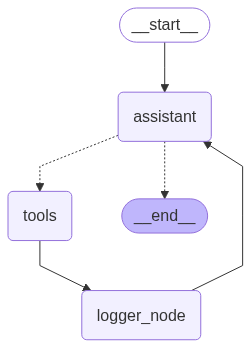

In [ ]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("logger_node", logger_node)

builder.add_edge(START, "assistant")

builder.add_conditional_edges(
    "assistant",
    tools_condition,
    {
        "tools": "tools",
        END: END
    }
)


builder.add_edge("tools", "logger_node")
builder.add_edge("logger_node", "assistant")

react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [25]:
# res = react_graph.invoke({"messages": [HumanMessage(content="Hi there!, how are you?")]})

In [1]:
# res = react_graph.invoke({"messages": [HumanMessage(content="Hi there!, how are you?")]})'")]})

In [2]:
# res

In [3]:
# for m in res["messages"]:
#     m.pretty_print()